### Downloading and Splitting the dataset

In [2]:
pip install ucimlrepo

In [3]:
pip install tensorflow

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)

# data (as pandas dataframes)
X = optical_recognition_of_handwritten_digits.data.features
y = optical_recognition_of_handwritten_digits.data.targets

# metadata
print(optical_recognition_of_handwritten_digits.metadata)

# variable information
print(optical_recognition_of_handwritten_digits.variables)


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess data
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11490434/11490434 [==============================] - 1s 0us/step


In [28]:
def create_model():
    model = models.Sequential([
        # Input shape is assumed to be 28x28 pixels with 1 color channel (grayscale)
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        # Only 2 max pooling layers are used to prevent the dimensions from becoming too small
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Output layer for 10 classes
    ])
    return model

model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 flatten_7 (Flatten)         (None, 6272)             

Epoch 1/10
1500/1500 [==============================] - 105s 69ms/step - loss: 0.2054 - accuracy: 0.9383 - val_loss: 0.0597 - val_accuracy: 0.9826
Epoch 2/10
1500/1500 [==============================] - 109s 72ms/step - loss: 0.0691 - accuracy: 0.9799 - val_loss: 0.0408 - val_accuracy: 0.9887
Epoch 3/10
1500/1500 [==============================] - 104s 69ms/step - loss: 0.0497 - accuracy: 0.9850 - val_loss: 0.0302 - val_accuracy: 0.9916
Epoch 4/10
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0398 - accuracy: 0.9886 - val_loss: 0.0326 - val_accuracy: 0.9924
Epoch 5/10
1500/1500 [==============================] - 109s 73ms/step - loss: 0.0325 - accuracy: 0.9901 - val_loss: 0.0355 - val_accuracy: 0.9901
Epoch 6/10
1500/1500 [==============================] - 106s 70ms/step - loss: 0.0250 - accuracy: 0.9928 - val_loss: 0.0367 - val_accuracy: 0.9912
Epoch 7/10
1500/1500 [==============================] - 109s 72ms/step - loss: 0.0215 - accuracy: 0.9935 - val_loss: 0

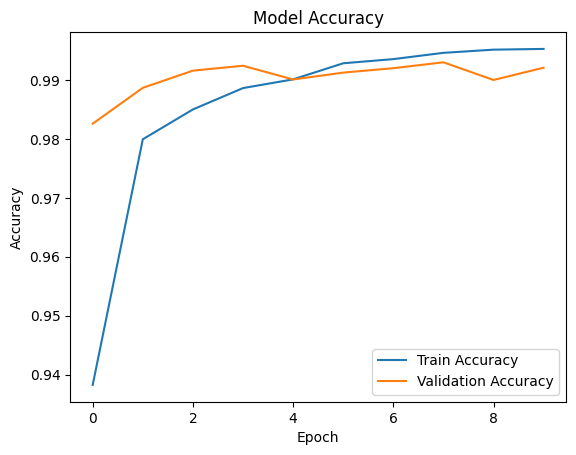

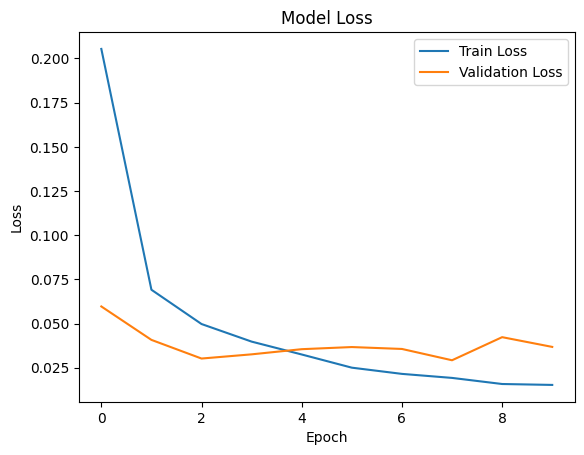

Epoch 1/10
 959/1500 [==================>...........] - ETA: 35s - loss: 0.2541 - accuracy: 0.9231

In [ ]:
# @title
# Setup K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

for train, val in kfold.split(train_images, np.argmax(train_labels, axis=1)):
    model = create_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model
    history = model.fit(train_images[train], train_labels[train], epochs=10,
                        validation_data=(train_images[val], train_labels[val]), verbose=1)

    # Evaluate the model
    scores = model.evaluate(train_images[val], train_labels[val], verbose=0)
    print(f"Fold accuracy: {scores[1]*100}%")
    cvscores.append(scores[1] * 100)

    # Plot training history
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Display average accuracy and the standard deviation
print(f"Mean CV Accuracy: {np.mean(cvscores):.2f}% (+/- {np.std(cvscores):.2f}%)")

In [15]:
# Predict the test set
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

313/313 [==============================] - 4s 14ms/step
Confusion Matrix:
[[ 976    1    0    0    0    0    1    1    1    0]
 [   0 1133    0    0    0    0    1    1    0    0]
 [   2    0 1028    0    0    0    0    1    1    0]
 [   0    0    0 1002    0    6    0    0    2    0]
 [   0    0    1    0  973    0    3    0    0    5]
 [   1    0    0    2    0  888    1    0    0    0]
 [   4    2    0    0    0    1  950    0    1    0]
 [   0    4    4    0    0    0    0 1015    1    4]
 [   1    0    1    0    1    0    0    0  970    1]
 [   0    1    1    0    5    3    1    0    3  995]]
